# Embedding's for MovieLens dataset

## Описание задачи

Необходимо построить векторное представление пользователей и фильмов используя нейросетевые подходы, чтобы можно было по эмбендингу пользователя искать похожие эмбендинги фильмов и рекомендовать ему их.

Обратить внимание на:

1. Какие данных на обучение и валидацию, обоснование.
2. Выбор и обоснование метрики
3. Разработка архитектуры нейронной сети с пояснением
4. Обучение и валидация
5. Решение должно быть воспроизводимым с подробными комментариями на каждом шаге

## Описание данных

*Полный* датасет MovieLens с сайта grouplens.org: https://files.grouplens.org/datasets/movielens/ml-latest.zip

В датасете содержится информация о фильмах, оценках пользователей и тегах фильмов.


Структура файла данных рейтингов (ratings.csv)
-----------------------------------------

Все рейтинги содержатся в файле `ratings.csv`. Каждая строка этого файла после строки заголовка представляет собой одну оценку одного фильма одним пользователем и имеет следующий формат:

    userId,movieId,rating,timestamp

Строки в этом файле упорядочены сначала по идентификатору пользователя, затем, внутри пользователя, по идентификатору фильма.

Оценки выставляются по 5-звездочной шкале, с шагом в ползвезды (0,5 звезды - 5,0 звезды).

Временные метки представляют собой секунды с полуночи по всемирному координированному времени (UTC) от 1 января 1970 года.


Структура файла данных тегов (tags.csv)
-----------------------------------

Все теги содержатся в файле `tags.csv`. Каждая строка этого файла после строки заголовка представляет собой один тег, примененный к одному фильму одним пользователем, и имеет следующий формат:

    userId,movieId,tag,timestamp

Строки в этом файле упорядочены сначала по userId, затем, внутри пользователя, по movieId.

Теги - это созданные пользователем метаданные о фильмах. Каждый тег обычно представляет собой одно слово или короткую фразу. Смысл, значение и цель конкретного тега определяется каждым пользователем.

Временные метки представляют собой секунды с полуночи по всемирному координированному времени (UTC) от 1 января 1970 года.


Структура файла данных фильмов (movies.csv)
---------------------------------------

Информация о фильмах содержится в файле `movies.csv`. Каждая строка этого файла после строки заголовка представляет один фильм и имеет следующий формат:

    movieId,title,genres

Названия фильмов вводятся вручную или импортируются из <https://www.themoviedb.org/> и включают год выпуска в круглых скобках. В этих названиях могут быть ошибки и несоответствия.

Жанры представляют собой список, разделенный трубкой, и выбираются из следующих:

* боевик
* Приключения
* Анимация
* Детские
* Комедия
* Криминал
* Документальный
* Драма
* Фэнтези
* Фильм-нуар
* Ужасы
* Мюзикл
* Мистерия
* Романтика
* Научная фантастика
* Триллер
* Война
* Вестерн
* (жанры не указаны)


Структура файла данных ссылок (links.csv)
---------------------------------------

Идентификаторы, которые могут быть использованы для ссылок на другие источники данных о фильмах, содержатся в файле `links.csv`. Каждая строка этого файла после строки заголовка представляет один фильм и имеет следующий формат:

    movieId,imdbId,tmdbId

movieId - это идентификатор для фильмов, используемых <https://movielens.org>. Например, фильм "История игрушек" имеет ссылку <https://movielens.org/movies/1>.

imdbId - это идентификатор для фильмов, используемых <http://www.imdb.com>. Например, фильм "История игрушек" имеет ссылку <http://www.imdb.com/title/tt0114709/>.

tmdbId - идентификатор для фильмов, используемых <https://www.themoviedb.org>. Например, фильм "История игрушек" имеет ссылку <https://www.themoviedb.org/movie/862>.

Использование перечисленных выше ресурсов регулируется условиями каждого поставщика.


Геном тегов (genome-scores.csv и genome-tags.csv)
-------------------------------------------------

Этот набор данных включает текущую копию генома тегов.

[genome-paper]: http://files.grouplens.org/papers/tag_genome.pdf

Геном тегов - это структура данных, которая содержит оценки релевантности тегов для фильмов.  Структура представляет собой плотную матрицу: каждый фильм в геноме имеет значение для *каждого* тега в геноме.

Как описано в [этой статье][genome-paper], геном тегов кодирует, насколько сильно фильмы проявляют определенные свойства, представленные тегами (атмосферность, заставляющие задуматься, реалистичность и т.д.). Геном тегов был вычислен с помощью алгоритма машинного обучения на пользовательском контенте, включая теги, рейтинги и текстовые рецензии.

Геном разделен на два файла.  Файл `genome-scores.csv` содержит данные о релевантности тегов фильма в следующем формате:

    movieId,tagId,relevance

Второй файл, `genome-tags.csv`, содержит описания тегов для идентификаторов тегов в файле генома в следующем формате:

    tagId,tag

Значения `tagId` генерируются при экспорте набора данных, поэтому они могут отличаться в разных версиях наборов данных MovieLens.

При ссылке на геномные данные тегов, пожалуйста, указывайте следующую цитату:

> Jesse Vig, Shilad Sen, and John Riedl. 2012. The Tag Genome: Кодирование знаний сообщества для поддержки новых взаимодействий. ACM Trans. Interact. Intell. Syst. 2, 3: 13:1-13:44. <https://doi.org/10.1145/2362394.2362395>

## Анализ данных

In [44]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
from pylab import rcParams
import matplotlib.pyplot as plt

from keras.layers import Dense , Dot, Dropout, Flatten, Input, Embedding
from keras.optimizers import Adam
from keras.models import Model

import requests
from io import BytesIO
from zipfile import ZipFile

Сделаем превечный осмотр данных

In [45]:
try:
    df = pd.read_csv('ml-latest/ratings.csv')
except:
    path = 'https://files.grouplens.org/datasets/movielens/ml-latest.zip'
    with ZipFile(BytesIO(requests.get(path).content)) as z:
        with z.open('ml-latest/ratings.csv') as f:
            df = pd.read_csv(f)

In [46]:
# get only 100_000 rows without random
df = df[:100_000]

In [47]:
df.head()

,userId,movieId,rating,timestamp
0,1,307,3.5,1256677221
1,1,481,3.5,1256677456
2,1,1091,1.5,1256677471
3,1,1257,4.5,1256677460
4,1,1449,4.5,1256677264


In [48]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100000 non-null  int64  
 1   movieId    100000 non-null  int64  
 2   rating     100000 non-null  float64
 3   timestamp  100000 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB


In [49]:
df = df.rename(columns={'userId': 'user_id', 'movieId': 'movie_id'})

In [50]:
rating_pre_user = df.groupby('user_id')['rating'].count()
rating_pre_movie = df.groupby('movie_id')['rating'].count()

print(f'Количество пользователей: {len(rating_pre_user)}')
print(f'Количество фильмов: {len(rating_pre_movie)}')
print()

print(f'Максимальная оценка: {df["rating"].max()}')
print(f'Минимальная оценка: {df["rating"].min()}')
print(f'Медианная оценка: {df["rating"].median()}')
print(f'Количество оценок: {df["rating"].count()}')
print()

print(f'Максимальное количество оценок на пользователя: {rating_pre_user.max()}')
print(f'Минимальное количество оценок на пользователя: {rating_pre_user.min()}')
print(f'Медианное количество оценок на пользователя: {rating_pre_user.median()}')
print()

print(f'Максимальное количество оценок на фильм: {rating_pre_movie.max()}')
print(f'Минимальное количество оценок на фильм: {rating_pre_movie.min()}')
print(f'Медианное количество оценок на фильм: {rating_pre_movie.median()}')

del rating_pre_user, rating_pre_movie

Количество пользователей: 1041
Количество фильмов: 9289

Максимальная оценка: 5.0
Минимальная оценка: 0.5
Медианная оценка: 4.0
Количество оценок: 100000

Максимальное количество оценок на пользователя: 1740
Минимальное количество оценок на пользователя: 1
Медианное количество оценок на пользователя: 29.0

Максимальное количество оценок на фильм: 350
Минимальное количество оценок на фильм: 1
Медианное количество оценок на фильм: 3.0


Данный вывод дает основное представление о данных. Все кажется отличным, кроме id фильмов. Он не имеет такого же порядка, как у id пользователя. Нужно будет при обучении создавать собственный словарь для id, чтобы не было проблем с размерностью.

In [51]:
print(f'Максимальный ID пользователя: {df["user_id"].max()}')
print(f'Минимальный ID пользователя: {df["user_id"].min()} \n')

print(f'Максимальный ID фильма: {df["movie_id"].max()}')
print(f'Минимальный ID фильма: {df["movie_id"].min()} \n')

print(f'Кол-во уникальных ID пользователей: {df["user_id"].nunique()}')
print(f'Кол-во уникальных ID фильмов: {df["movie_id"].nunique()}')

Максимальный ID пользователя: 1041
Минимальный ID пользователя: 1 

Максимальный ID фильма: 192579
Минимальный ID фильма: 1 

Кол-во уникальных ID пользователей: 1041
Кол-во уникальных ID фильмов: 9289


Данный вывод, так же, подтверждает необходимость создания собственного словаря для id.

In [52]:
df.isna().sum()

user_id      0
movie_id     0
rating       0
timestamp    0
dtype: int64

In [53]:
df.duplicated().sum()

0

В данных не обнаружено пропусков и дубликатов. Можно приступать к подготовке данных.

## Подготовка данных

In [54]:
df['user_id'] = df['user_id'].astype('category').cat.codes.values
df['movie_id'] = df['movie_id'].astype('category').cat.codes.values

In [55]:
df['user_id'].value_counts(ascending=True).head()

user_id
843     1
1015    1
533     1
1007    1
32      1
Name: count, dtype: int64

In [56]:
users = df['user_id'].unique()
movies = df['movie_id'].unique()

userid2idx = {o:i for i,o in enumerate(users)}
movieid2idx = {o:i for i,o in enumerate(movies)}

df['user_id'] = df['user_id'].apply(lambda x: userid2idx[x])
df['movie_id'] = df['movie_id'].apply(lambda x: movieid2idx[x])

Как я и говорил, создадим собственный словарь для id и перезапишем id в датасете. Так мы можем быть уверены, что размерность данных будет соответствовать размерности векторов.

Нужно произвести разделение данных на обучающую и тестовую выборки. Для этого воспользуемся функцией из статьи [Сравнение матричной факторизации с трансформерами на наборе данных MovieLens с применением библиотеки pytorch-acceleratd](https://habr.com/ru/companies/wunderfund/articles/645921/).

Данные функции не позволят допустить утечки данных в тестовую выборку. И оценка качества модели будет более объективной.

In [57]:
def get_last_n_ratings_by_user(
        df, n, min_ratings_per_user=1, user_colname="user_id", timestamp_colname="timestamp"
):
    return (
        df.groupby(user_colname)
        .filter(lambda x: len(x) >= min_ratings_per_user)
        .sort_values(timestamp_colname)
        .groupby(user_colname)
        .tail(n)
        .sort_values(user_colname)
    )

In [58]:
def mark_last_n_ratings_as_validation_set(
        df, n, min_ratings=1, user_colname="user_id", timestamp_colname="timestamp"
):
    """
    Отмечает n последних по времени оценок, что включает их в проверочную выборку.
    Делается это путём добавления дополнительного столбца 'is_valid' в df.
    :param df: объект DataFrame, содержащий оценки, данные пользователем
    :param n: количество оценок, которые надо включить в проверочную выборку
    :param min_ratings: включать лишь пользователей, имеющих более этого количества оценок
    :param user_id_colname: имя столбца, содержащего идентификатор пользователя
    :param timestamp_colname: имя столбца, содержащего отметку времени
    :return: тот же df, в который добавлен дополнительный столбец 'is_valid'
    """
    df["is_valid"] = False
    df.loc[
        get_last_n_ratings_by_user(
            df,
            n,
            min_ratings,
            user_colname=user_colname,
            timestamp_colname=timestamp_colname,
        ).index,
        "is_valid",
    ] = True
    return df

In [81]:
mark_last_n_ratings_as_validation_set(df, n=8, min_ratings=20);

In [82]:
train_df = df[df['is_valid'] == False].drop(columns=['is_valid'])
test_df = df[df['is_valid'] == True].drop(columns=['is_valid'])

Применяем функции для разделения данных на обучающую и тестовую выборки. Мы берем каждого 8 пользователя у которого оценено больше 20 фильмов и помечаем их как тестовые. И на основе этих пометок создаем два датасета `train_df` и `test_df`.

In [83]:
# show ratio of train and test data
print(f'Количество строк в тренировочном датасете: {len(train_df)}')
print(f'Количество строк в тестовом датасете: {len(test_df)}')
print(f'Отношение тренировочного датасета к тестовому: {len(train_df) / len(test_df)}')

Количество строк в тренировочном датасете: 95032
Количество строк в тестовом датасете: 4968
Отношение тренировочного датасета к тестовому: 19.128824476650564


Примерное соотношение 80/20. Почти, 20% данных будет достаточно для тестирования модели. Произведем разделение данных на обучающую и валидационную выборки, по такому же принципу.

In [84]:
train_df = mark_last_n_ratings_as_validation_set(train_df, n=10, min_ratings=20)

In [85]:
train = train_df[train_df['is_valid'] == False].drop(columns=['is_valid'])
valid = train_df[train_df['is_valid'] == True].drop(columns=['is_valid'])

del train_df

In [86]:
(train.shape , valid.shape, test_df.shape)

((91798, 4), (3234, 4), (4968, 4))

In [65]:
train.head()

,user_id,movie_id,rating,timestamp
0,0,0,3.5,1256677221
1,0,1,3.5,1256677456
2,0,2,1.5,1256677471
3,0,3,4.5,1256677460
4,0,4,4.5,1256677264


## Построение модели

In [66]:
n_movies = len(df['movie_id'].unique())
n_users = len(df['user_id'].unique())

n_latent_factors = 50
dropout_rate = 0.4

In [67]:
user_input = Input(shape=(1,), name='user_input', dtype='int64')
user_embedding = Embedding(n_users, n_latent_factors, name='user_embedding')(user_input)
user_vec = Flatten(name='FlattenUsers')(user_embedding)
user_vec = Dropout(dropout_rate)(user_vec)

In [68]:
movie_input = Input(shape=(1,), name='movie_input', dtype='int64')
movie_embedding = Embedding(n_movies, n_latent_factors, name='movie_embedding')(movie_input)
movie_vec = Flatten(name='FlattenMovies')(movie_embedding)
movie_vec = Dropout(dropout_rate)(movie_vec)

In [69]:
sim = Dot(name='Similarity', axes=1)([user_vec, movie_vec])

In [70]:
nn_inp = Dense(96, activation='relu')(sim)
nn_inp = Dropout(dropout_rate)(nn_inp)
nn_inp = Dense(1, activation='relu')(nn_inp)
nn_model = Model([user_input, movie_input], nn_inp)
nn_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 user_input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 movie_input (InputLayer)       [(None, 1)]          0           []                               
                                                                                                  
 user_embedding (Embedding)     (None, 1, 50)        52050       ['user_input[0][0]']             
                                                                                                  
 movie_embedding (Embedding)    (None, 1, 50)        464450      ['movie_input[0][0]']            
                                                                                              

In [71]:
nn_model.compile(optimizer=Adam(lr=1e-3), loss='mse')

In [72]:
batch_size = 128
epochs = 20

In [73]:
history = nn_model.fit(
    x=[train['user_id'], train['movie_id']],
    y=train['rating'],
    batch_size=batch_size,
    epochs=epochs,
    validation_data=([valid['user_id'], valid['movie_id']], valid['rating']),
    verbose=1
)

Epoch 1/20
709/709 [==============================] - 4s 4ms/step - loss: 2.7475 - val_loss: 1.2261
Epoch 2/20
709/709 [==============================] - 2s 4ms/step - loss: 1.3024 - val_loss: 1.1582
Epoch 3/20
709/709 [==============================] - 3s 4ms/step - loss: 1.0299 - val_loss: 1.0740
Epoch 4/20
709/709 [==============================] - 2s 3ms/step - loss: 0.8877 - val_loss: 1.0413
Epoch 5/20
709/709 [==============================] - 3s 4ms/step - loss: 0.7954 - val_loss: 1.0322
Epoch 6/20
709/709 [==============================] - 3s 4ms/step - loss: 0.7388 - val_loss: 1.0177
Epoch 7/20
709/709 [==============================] - 3s 4ms/step - loss: 0.6942 - val_loss: 1.0124
Epoch 8/20
709/709 [==============================] - 3s 4ms/step - loss: 0.6546 - val_loss: 1.0077
Epoch 9/20
709/709 [==============================] - 3s 4ms/step - loss: 0.6286 - val_loss: 1.0084
Epoch 10/20
709/709 [==============================] - 3s 4ms/step - loss: 0.5959 - val_loss: 0.9996

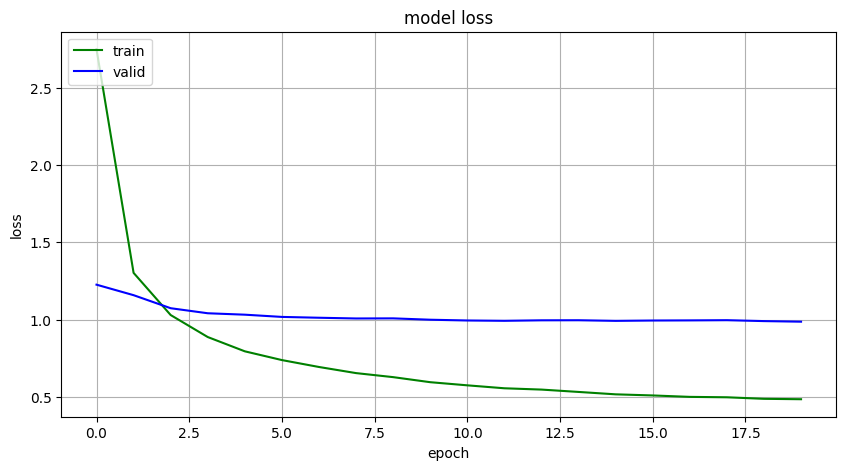

In [74]:
rcParams['figure.figsize'] = 10, 5

plt.plot(history.history['loss'] , 'g')
plt.plot(history.history['val_loss'] , 'b')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.grid(True)
plt.show()

In [75]:
# evaluate model
nn_model.evaluate(x=[test_df['user_id'], test_df['movie_id']], y=test_df['rating'])

156/156 [==============================] - 0s 1ms/step - loss: 0.9981


0.9980576634407043

In [76]:
user_embeddings = nn_model.get_layer('user_embedding').get_weights()[0]
movie_embeddings = nn_model.get_layer('movie_embedding').get_weights()[0]

In [77]:
# make recommendations
user_id = 1
user_embedding = user_embeddings[user_id-1]

movie_embeddings_norm = movie_embeddings / np.linalg.norm(movie_embeddings, axis = 1).reshape((-1, 1))
scores = user_embedding.dot(movie_embeddings_norm.T)

In [78]:
top_movies = np.argpartition(scores, -10)[-10:]

In [79]:
top_movies

array([ 549, 9207, 7154, 6456, 2679, 3743, 7039,  847,   66,   92],
      dtype=int64)